In [72]:
from ast import If
import json
import csv
import os
import glob
import numpy as np
import playerData

jsonFiles = []
csvFiles = []
playersArray = []
numNiveles = 4
nivel = -1
tiempoInicioNivel = 0
muertesPorNivel = np.zeros(numNiveles) #esto mide la suma de todas las muertes hechas por todos los jugadores?¿
saltosPorNivel = np.zeros(numNiveles)  #esto mide la suma de todos los saltos hechos por todos los jugadores?¿
numArchivos = 0
zone = -1
zonasEspeciales = None
isPlayerInZone = 0 #flag para las zonas especiales

specialZoneTimestamp = 0

def initZonasEspeciales():
    global zonasEspeciales
    zonasEspeciales = [[] for i in range(numNiveles)]
    zonasEspeciales[0].append([[23, 3], [26, 0]])

def getCollision(x, y, rect):
                #rect->arribaizq->x
        return (x > rect[0][0] and
                #rect->abajodcha->x
                x < rect[1][0] and
                #rect->arribaizq->y
                y < rect[0][1] and
                #rect->abajodcha->y
                y > rect[1][1])

def ProcessJson(f):
    Lines = f.readlines()
    count = 0
    # For each line process one event
    events = []
    for line in Lines:
        count += 1
        events.append(json.loads(line))
    return events

def ProcessCSV(f):

    players = []

    ncol = len(next(f))
    start = 3

    for row in f:
        answers = []
        name = str(row[start - 1])
        name = "".join([ch for ch in name if ch.isdigit()])   # getONLY the numbers in the name
        
        for x in range(start, ncol):
            answers.append(row[x])
        player = name, answers
        players.append(player)
    
    return players



# def Clean(f):
#     session_start = []
#     for i in range(0, f.readlines, 1):
#         line = f.readline[i]   

def ReadFiles():
    #List of files in folder
    for filename in glob.glob('**/*.json'):
        with open(filename, mode="r", encoding="utf-8") as f: # open files in readonly mode
            fName = f.name
            fName = "".join([ch for ch in fName if ch.isdigit()])   # getONLY the numbers in the name
            file = str(fName), ProcessJson(f)
            jsonFiles.append(file)
            player = playerData.Player(numNiveles, zonasEspeciales)
            playersArray.append(player)
            global numArchivos
            numArchivos += 1
            
    for filename in glob.glob('*.csv'):
        with open(filename, mode="r", encoding="utf-8") as f:
            csvreader = csv.reader(f)
            file = str(f.name), ProcessCSV(csvreader)
            csvFiles.append(file)
            


In [73]:
def SessionStart(e,player):
    ID = e["sesion"]
    player.setID(ID)
def SessionEnd(e,player):
    player.end()
def LevelStart(e,player):
    global nivel
    nivel = e["nivel"] -3 #Los niveles estan codificados como nivel 3, 4, 5 y 6, asi que les resto esto para que se guarden como 0,1,2, y 3.
    player.resetPath(nivel)

    #si no ha llegado al final del nivel, pero si lo ha empezado antes (p.ej: si se buggea y reinicia), borra los datos de ese nivel
    if (not player.hasLevelBeenCompleted(nivel)):
        player.resetLevelInfo(nivel)
        global tiempoInicioNivel
        tiempoInicioNivel = e["tiempo"]

def LevelEnd(e, player):
    player.lvlEnd(e["tiempo"] - tiempoInicioNivel)

def Pause(e, player):
    player.pause(e["tiempo"])

def Unpause(e, player):
    player.pause(e["tiempo"])

def Death(e, player):
    muertesPorNivel[nivel] += 1
    player.death(nivel)

def Collision(e, player):
    player.collision(e["tag"], e["id"])


def Jump(e, player):
    saltosPorNivel[nivel] += 1
    player.jump(nivel)
    if (CheckSpecialZone(e, player)):
        player.jumpEspecial(nivel, zone)
            

def PlayerPosition(e, player):
    pos = e["x"], e["y"]
    player.addToPath(pos, nivel)
    CheckSpecialZone(e, player)



def CheckSpecialZone(e, player):
    b = False
    for zona in range(len(zonasEspeciales[nivel])):
        if (getCollision(e["x"], e["y"], zonasEspeciales[nivel][zona])):
            b = True
            global isPlayerInZone
            global specialZoneTimestamp
            if(isPlayerInZone == 0):
                global zone
                zone = zona
                #guardar el tiempo inical
                isPlayerInZone = 1
                print("Tiempo inicial: ", e["tiempo"])
                specialZoneTimestamp = e["tiempo"] #primer salto
        elif (isPlayerInZone == 1):
            #ha salido de la zona especial
            isPlayerInZone = 0
            print("Tiempo final: ", e["tiempo"])
            time = e["tiempo"] - specialZoneTimestamp
            player.tiempoEspecial(nivel,zona,time)
    return b


In [74]:
def FormularioEnd(p):
        player = playersArray[p]
        player.formularioInforme()

def Age(a, player):
        player.setAge(a)

def GeneralExperience(a, player):
        player.setGeneralExperience(a)

def PlatformExperience(a, player):
        player.setPlatformExperience(a)

def Walljump(a, player):
        player.setWalljump(a)

def Gravity(a, player):
        player.setGravity(a)
        
def LevelDificulty(level, a, player):
        player.setLevelDificulty(level, a)
        
def PlatformExperience(a, player):
        player.setPlatformExperience(a)

def Walljump(a, player):
        player.setWalljump(a)

def Gravity(a, player):
        player.setGravity(a)
        
def LevelDificulty(level, a, player):
        player.setLevelDificulty(level, a)

In [75]:
def ProcessEvent(e,actualPlayer):
     nombre = e["nombre"]
     player = playersArray[actualPlayer] #algunos eventos usaran al jugador y otros no

     if nombre == "LEVEL_START":
          LevelStart(e,player)

     elif nombre == "SESSION_START":
          SessionStart(e,player)
          
     elif nombre == "SESSION_END": #descomentar para leer informes individuales
          SessionEnd(e,player)

     #no tiene en cuenta los eventos de debajo si ya ha completado el nivel antes
     if (player.hasLevelBeenCompleted(nivel)): 
          return

     if nombre == "LEVEL_END":
          LevelEnd(e, player)


     elif nombre == "PAUSE":
          Pause(e, player)

     elif nombre == "UNPAUSE":
          Unpause(e, player)

     elif nombre == "DEATH":
          Death(e,player)

     elif nombre == "COLLISION":
          Collision(e, player)

     elif nombre == "JUMP":
          Jump(e,player)

     elif nombre == "PLAYER_POSITION":
          PlayerPosition(e,player)


     #print(nivel,":",nombre)




In [76]:
def ProcessAnswer(a, actualAnswer, actualPlayer):
    player = playersArray[actualPlayer]

    if(actualAnswer == 0):
        Age(a, player)

    elif(actualAnswer == 1):
        GeneralExperience(a, player)
        
    elif(actualAnswer == 2):
        PlatformExperience(a, player)
        
    elif(actualAnswer == 3):
        Walljump(a, player)
    
    elif(actualAnswer == 4):
        Gravity(a, player)
    
    elif(actualAnswer >= 5):
        LevelDificulty(actualAnswer - 5, a, player)
        

In [77]:

def ProcessFiles():
    initZonasEspeciales()
    ReadFiles()
    actualPlayer = -1 #iterador para añadir datos de jugador
    for f in jsonFiles:
        actualPlayer+=1
        print("Processing player", actualPlayer)
        for e in f[1]:
            ProcessEvent(e,actualPlayer)
    
    for f in csvFiles:
        for p in f[1]:
            index = 0
            found = False
            actualPlayer = 0

            for n in playersArray:
                if str(n.ID) == p[0]:
                    actualPlayer = index
                    found = True
                    break
                else: index += 1

            if found == True:
                print("Processing formulary", actualPlayer)
                actualAnswer= 0
                for a in p[1]:
                    ProcessAnswer(a, actualAnswer, actualPlayer)
                    actualAnswer += 1
                FormularioEnd(actualPlayer)
            else: print("Wrong ID: ", p[0], "\n---------------------------------------------")
                
            
            
    print("------------------------------------------")
    print("Media de saltos por jugador en cada nivel:",saltosPorNivel/np.size(playersArray))
    print("Media de muertes por jugador en cada nivel:",muertesPorNivel/np.size(playersArray))

ProcessFiles()

Processing player 0
Tiempo inicial:  13.667265892028809
Tiempo final:  14.667717933654785
INFORME JUGADOR  1030424204065505273
Jumps:  [11. 37. 17. 37.]
Deaths:  [0. 0. 0. 0.]
Tiempo por nivel:  [11.34498215 38.04221344 27.28330612 52.60284424]
Tiempo en pausa:  [0. 0. 0. 0.]
Cambios de gravedad:  [{}, {}, {3658: 8}, {4330: 1, 4326: 1, 4328: 1, 4334: 1, 4332: 7, 4336: 3}]
Saltos por zonas especiales en el nivel  0 [3.]
Saltos por zonas especiales en el nivel  1 []
Saltos por zonas especiales en el nivel  2 []
Saltos por zonas especiales en el nivel  3 []
Tiempo por zonas especiales:  0 [1.00045204]
Tiempo por zonas especiales:  1 []
Tiempo por zonas especiales:  2 []
Tiempo por zonas especiales:  3 []
---------------------------------------------
Processing player 1
Tiempo inicial:  50.400169372558594
Tiempo final:  57.50279235839844
Tiempo inicial:  91.89002990722656
Tiempo final:  96.8948745727539
INFORME JUGADOR  1060054125199479874
Jumps:  [ 16. 104.  27.  35.]
Deaths:  [0. 2. 0. 0

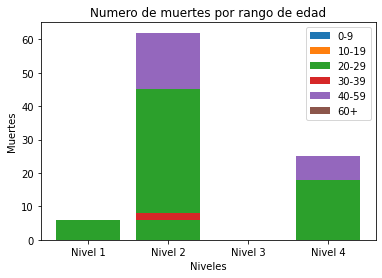

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.misc as sci
import imageio
from PIL import Image

#im = imageio.imread("guille.jpg")
#plt.imshow(im)
#Create the heatmap
#kde = sns.kdeplot(
        #map(lambda x: x[0],  playersArray[0].paths[3]),
        #map(lambda x: x[1],  playersArray[0].paths[3]),
        #shade = True,
        #shade_lowest=False,
        #alpha=.5,
        #n_levels=10,
        #cmap = 'magma'
#)

def grafico_paths(): #grafico que mete todos los paths en una unica imagen
        limits = [[[-8,35],[-3,8]], #nivel 1 (xlimit, ylimit)
                [[-45,45],[-2,10]],
                [[-5,45],[-15,25]],
                [[-30,+30],[-15,15]]]
        global numNiveles
        for i in range(numNiveles):
                plt.xlim = limits[i][0]
                plt.ylim = limits[i][1]
                for p in playersArray:
                        x = [pos[0] for pos in p.paths[i]]
                        y = [pos[1] for pos in p.paths[i]]
                        title = 'Caminos en el nivel', i+1
                        plt.title(title)
                        plt.plot(x,y)
                plt.show()
def graficoMuertesPorNivel():
        x = ['Nivel 1', 'Nivel 2', 'Nivel 3', 'Nivel 4']
        altura = muertesPorNivel
        plt.bar(x,altura)
        plt.title('Número de muertes totales por nivel')
        plt.show()
def graficoMuertesVSEdad():
        niveles = ['Nivel 1', 'Nivel 2', 'Nivel 3', 'Nivel 4']
        indice = np.arange(len(niveles))      
        rangosEdad = [] #6 rangos de edad
        for i in range(6):
                rangosEdad.append(np.zeros(numNiveles))

        labels = ['0-9', '10-19', '20-29', '30-39', '40-59', '60+']
        for p in playersArray:
                age = p.age
                if age == '0-9':
                        rangosEdad[0]+=p.nDeaths
                elif age == '10-19':
                        rangosEdad[1]+=p.nDeaths
                elif age == '20-29':
                        rangosEdad[2]+=p.nDeaths
                elif age == '30-39':
                        rangosEdad[3]+=p.nDeaths
                elif age == '40-59':
                        rangosEdad[4]+=p.nDeaths
                elif age == '60+':
                        rangosEdad[5]+=p.nDeaths

        plt.bar(indice,rangosEdad[0], label = labels[0])
        for i in range(len(rangosEdad)-1):
                plt.bar(indice,rangosEdad[i+1], label = labels[i+1], bottom = rangosEdad[i-1])

        plt.xticks(indice,niveles)
        plt.ylabel("Muertes")
        plt.xlabel("Niveles")
        plt.title("Numero de muertes por rango de edad")
        plt.legend()

        plt.show()



                        
        

#grafico_paths()
#graficoMuertesPorNivel()
graficoMuertesVSEdad()